In [100]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [101]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [102]:
#load data
mnist_train = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

mnist_test = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

# make validation set

train_length = len(mnist_train)
train_size = int(0.85 * train_length)
val_size = train_length - train_size

mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [train_size, val_size])

# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []
train_acc_list = []
val_acc_list = []

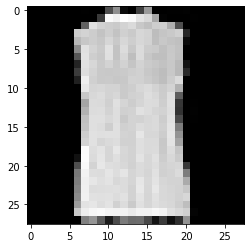

In [103]:
# visualise sample of data to know what we are dealing with
plt.figure(1)
img, label = mnist_train[5]
plt.imshow(img.squeeze(), cmap='gray')

In [104]:
img.size()

torch.Size([1, 28, 28])

In [105]:
# make network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 16 from batchnorm, 14 from pooling
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(128,10)
        # self.act2 = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64 * 7 * 7)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        # out = self.act2(out)
        return out


In [116]:
# train and test loop
def train_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):

    best_val_acc = 0.0
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        train_total = 0.0
        train_correct = 0.0
        val_total = 0.0
        val_correct = 0.0
        for imgs, labels in train_loader:
            # move tensors to gpu
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)

            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            train_total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            train_correct += int((predicted == labels).sum())



        epoch_list.append(epoch)
        train_loss_list.append(loss_train / len(train_loader))

        # get loss of validation data
        with torch.no_grad():
            loss_val = 0.0


            for imgs, labels in val_loader:
                # move tensors to gpu if available
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)

                loss_v = loss_fn(outputs, labels)

                loss_val += loss_v.item()

                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
                val_total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
                val_correct += int((predicted == labels).sum())



        val_loss_list.append(loss_val / len(val_loader))

        val_acc = val_correct/val_total

        train_acc_list.append(train_correct/train_total)
        val_acc_list.append(val_acc)

        if val_acc > best_val_acc:
            print('Found better model')
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'mnist_digits_nn.pt')

        # set when to print info about training progress
        if epoch == 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {:.4f}, Validation loss {:.4f}, Train Acc {:.4f}, Val Acc {:.4f}'.format(epoch, loss_train / len(train_loader), loss_val / len(val_loader), train_correct/train_total, val_acc),
                  )
            print('Best Val Acc {:.4f}'.format(best_val_acc))
        

    model = Net()
    model.load_state_dict(torch.load('mnist_digits_nn.pt'))


def test_loop(model, test_loader):
    correct = 0.0
    total = 0.0

    with torch.no_grad():
        for imgs, labels in test_loader:
            # move to gpu
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())


    print("Accuracy test: {:.4f} %".format(correct / total))

In [117]:
# set model and params
n_epochs = 3
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test,  batch_size=64, shuffle=False)
# epoch_num_of_no_improve = 5


train_loop(
    n_epochs = n_epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)


print('Accuracy score')
test_loop(model, val_loader)
print('Test score')
test_loop(model, test_loader)



Found better model
Epoch 1, Training loss 0.5530, Validation loss 0.3133, Train Acc 0.8299, Val Acc 0.8914
Best Val Acc 0.8914
Accuracy test: 0.8914 %
Found better model
Epoch 2, Training loss 0.2919, Validation loss 0.2780, Train Acc 0.8944, Val Acc 0.9002
Best Val Acc 0.9002
Accuracy test: 0.9002 %
Found better model
Epoch 3, Training loss 0.2543, Validation loss 0.2559, Train Acc 0.9088, Val Acc 0.9062
Best Val Acc 0.9062
Accuracy test: 0.9062 %
Accuracy test: 0.8997 %


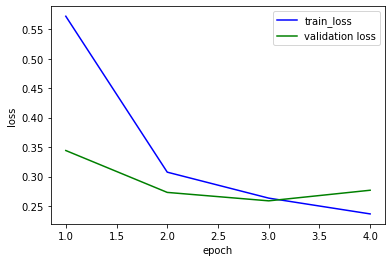

In [108]:
plt.figure(2)
plt.plot(epoch_list, train_loss_list, color='blue', label='train_loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

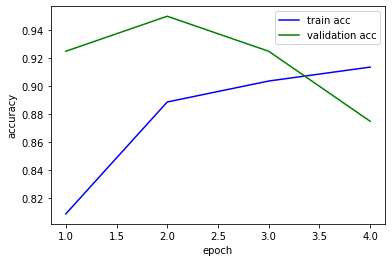

In [109]:
plt.figure(3)
plt.plot(epoch_list, train_acc_list, color='blue', label='train acc')
plt.plot(epoch_list, val_acc_list, color='green', label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Text(230.20000000000005, 0.5, 'predicted label')

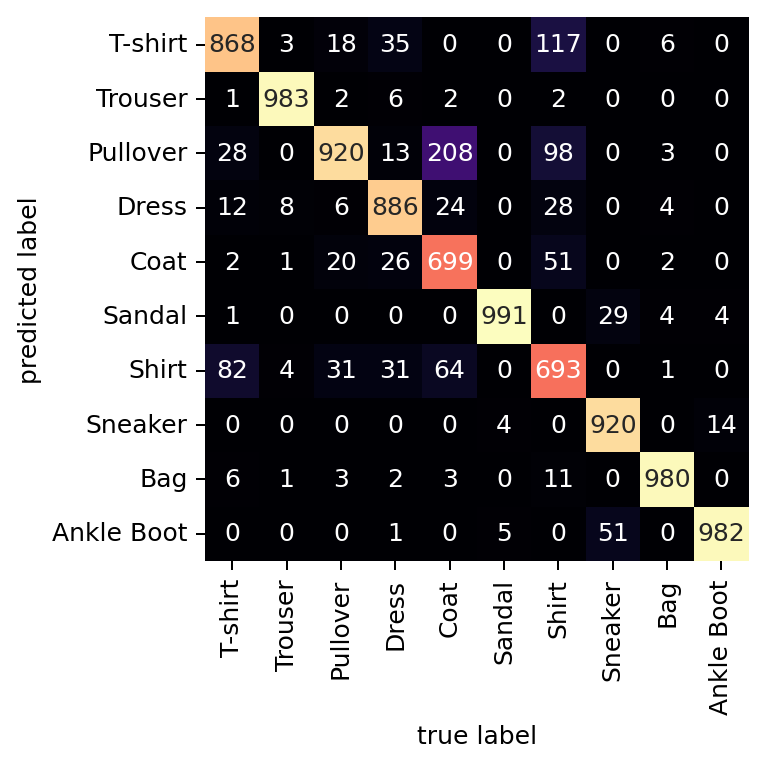

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_fit = np.array([])
y_test = np.array([])

for imgs, labels in test_loader:
    model = model.to('cpu')

    outputs = model(imgs)

    _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
    predicted = predicted.detach().numpy()
    labels = labels.detach().numpy()
    y_fit = np.concatenate((y_fit, predicted), axis=None)
    y_test = np.concatenate((y_test, labels), axis=None)
    # y_fit.append(predicted)
    # y_test.append(labels)

labels_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

plt.figure(6, dpi=180)
conf_matrix = confusion_matrix(y_test, y_fit)
conf_matrix = pd.DataFrame(conf_matrix)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names, cmap='magma')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [111]:
import torch.onnx as onnx
import torchvision.models as models

model = models.vgg16(pretrained=True)
torch.save(model.state_dict(), 'model_weights_fashion_mnist.pth')